In [1]:
from utils import *
import tensorflow as tf
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
trainset = sklearn.datasets.load_files(container_path = 'data', encoding = 'UTF-8')
trainset.data, trainset.target = separate_dataset(trainset,1.0)
print(trainset.target_names)
print(len(trainset.data))
print(len(trainset.target))

['negative', 'positive']
10662
10662


In [3]:
window_size = 2
n_topics = 10
embedding_size = 128
epoch = 5
switch_loss = 3

In [4]:
class LDA2VEC:
    def __init__(
        self,
        num_unique_documents,
        vocab_size,
        num_topics,
        freqs,
        embedding_size = 128,
        num_sampled = 40,
        learning_rate = 1e-3,
        lmbda = 150.0,
        alpha = None,
        power = 0.75,
        batch_size = 32,
        clip_gradients = 5.0,
        **kwargs
    ):
        moving_avgs = tf.train.ExponentialMovingAverage(0.9)
        self.batch_size = batch_size
        self.freqs = freqs
        self.sess = tf.InteractiveSession()

        self.X = tf.placeholder(tf.int32, shape = [None])
        self.Y = tf.placeholder(tf.int64, shape = [None])
        self.DOC = tf.placeholder(tf.int32, shape = [None])
        step = tf.Variable(0, trainable = False, name = 'global_step')
        self.switch_loss = tf.Variable(0, trainable = False)
        train_labels = tf.reshape(self.Y, [-1, 1])
        sampler = tf.nn.fixed_unigram_candidate_sampler(
            train_labels,
            num_true = 1,
            num_sampled = num_sampled,
            unique = True,
            range_max = vocab_size,
            distortion = power,
            unigrams = self.freqs,
        )

        self.word_embedding = tf.Variable(
            tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0)
        )
        self.nce_weights = tf.Variable(
            tf.truncated_normal(
                [vocab_size, embedding_size],
                stddev = tf.sqrt(1 / embedding_size),
            )
        )
        self.nce_biases = tf.Variable(tf.zeros([vocab_size]))
        scalar = 1 / np.sqrt(num_unique_documents + num_topics)
        self.doc_embedding = tf.Variable(
            tf.random_normal(
                [num_unique_documents, num_topics],
                mean = 0,
                stddev = 50 * scalar,
            )
        )
        self.topic_embedding = tf.get_variable(
            'topic_embedding',
            shape = [num_topics, embedding_size],
            dtype = tf.float32,
            initializer = tf.orthogonal_initializer(gain = scalar),
        )
        pivot = tf.nn.embedding_lookup(self.word_embedding, self.X)
        proportions = tf.nn.embedding_lookup(self.doc_embedding, self.DOC)
        doc = tf.matmul(proportions, self.topic_embedding)
        doc_context = doc
        word_context = pivot
        context = tf.add(word_context, doc_context)
        loss_word2vec = tf.reduce_mean(
            tf.nn.nce_loss(
                weights = self.nce_weights,
                biases = self.nce_biases,
                labels = self.Y,
                inputs = context,
                num_sampled = num_sampled,
                num_classes = vocab_size,
                num_true = 1,
                sampled_values = sampler,
            )
        )
        self.fraction = tf.Variable(1, trainable = False, dtype = tf.float32)

        n_topics = self.doc_embedding.get_shape()[1].value
        log_proportions = tf.nn.log_softmax(self.doc_embedding)
        if alpha is None:
            alpha = 1.0 / n_topics
        loss = -(alpha - 1) * log_proportions
        prior = tf.reduce_sum(loss)

        loss_lda = lmbda * self.fraction * prior
        self.cost = tf.cond(
            step < self.switch_loss,
            lambda: loss_word2vec,
            lambda: loss_word2vec + loss_lda,
        )
        loss_avgs_op = moving_avgs.apply([loss_lda, loss_word2vec, self.cost])
        with tf.control_dependencies([loss_avgs_op]):
            self.optimizer = tf.contrib.layers.optimize_loss(
                self.cost,
                tf.train.get_global_step(),
                learning_rate,
                'Adam',
                clip_gradients = clip_gradients,
            )
        self.sess.run(tf.global_variables_initializer())

    def train(
        self, pivot_words, target_words, doc_ids, num_epochs, switch_loss = 3
    ):
        from tqdm import tqdm

        temp_fraction = self.batch_size / len(pivot_words)
        self.sess.run(tf.assign(self.fraction, temp_fraction))
        self.sess.run(tf.assign(self.switch_loss, switch_loss))
        for e in range(num_epochs):
            pbar = tqdm(
                range(0, len(pivot_words), self.batch_size),
                desc = 'minibatch loop',
            )
            for i in pbar:
                batch_x = pivot_words[
                    i : min(i + self.batch_size, len(pivot_words))
                ]
                batch_y = target_words[
                    i : min(i + self.batch_size, len(pivot_words))
                ]
                batch_doc = doc_ids[
                    i : min(i + self.batch_size, len(pivot_words))
                ]
                _, cost = self.sess.run(
                    [self.optimizer, self.cost],
                    feed_dict = {
                        self.X: batch_x,
                        self.Y: batch_y,
                        self.DOC: batch_doc,
                    },
                )
                pbar.set_postfix(cost = cost, epoch = e + 1)

In [5]:
import random
from sklearn.utils import shuffle

def skipgrams(
    sequence,
    vocabulary_size,
    window_size = 4,
    negative_samples = 1.0,
    shuffle = True,
    categorical = False,
    sampling_table = None,
    seed = None,
):
    couples = []
    labels = []
    for i, wi in enumerate(sequence):
        if not wi:
            continue
        if sampling_table is not None:
            if sampling_table[wi] < random.random():
                continue

        window_start = max(0, i - window_size)
        window_end = min(len(sequence), i + window_size + 1)
        for j in range(window_start, window_end):
            if j != i:
                wj = sequence[j]
                if not wj:
                    continue
                couples.append([wi, wj])
                if categorical:
                    labels.append([0, 1])
                else:
                    labels.append(1)

    if negative_samples > 0:
        num_negative_samples = int(len(labels) * negative_samples)
        words = [c[0] for c in couples]
        random.shuffle(words)

        couples += [
            [words[i % len(words)], random.randint(1, vocabulary_size - 1)]
            for i in range(num_negative_samples)
        ]
        if categorical:
            labels += [[1, 0]] * num_negative_samples
        else:
            labels += [0] * num_negative_samples

    if shuffle:
        if seed is None:
            seed = random.randint(0, 10e6)
        random.seed(seed)
        random.shuffle(couples)
        random.seed(seed)
        random.shuffle(labels)

    return couples, labels

In [6]:
bow = CountVectorizer().fit(trainset.data)
transformed = bow.transform(trainset.data)
idx_text_clean, len_idx_text_clean = [], []
for text in transformed:
    splitted = text.nonzero()[1]
    idx_text_clean.append(splitted)
    
dictionary = {
        i: no for no, i in enumerate(bow.get_feature_names())
    }
reversed_dictionary = {
        no: i for no, i in enumerate(bow.get_feature_names())
    }
freqs = transformed.toarray().sum(axis = 0).tolist()
doc_ids = np.arange(len(idx_text_clean))
num_unique_documents = doc_ids.max()
pivot_words, target_words, doc_ids = [], [], []
for i, t in enumerate(idx_text_clean):
    pairs, _ = skipgrams(
            t,
            vocabulary_size = len(dictionary),
            window_size = window_size,
            shuffle = True,
            negative_samples = 0,
        )
    for pair in pairs:
        temp_data = pair
        pivot_words.append(temp_data[0])
        target_words.append(temp_data[1])
        doc_ids.append(i)
pivot_words, target_words, doc_ids = shuffle(
        pivot_words, target_words, doc_ids, random_state = 10
)
num_unique_documents = len(idx_text_clean)

In [7]:
model = LDA2VEC(
        num_unique_documents,
        len(dictionary),
        n_topics,
        freqs,
        embedding_size = embedding_size)

In [8]:
model.train(
    pivot_words, target_words, doc_ids, epoch, switch_loss = switch_loss
)

minibatch loop: 100%|██████████| 11987/11987 [01:40<00:00, 119.71it/s, cost=-1.16e+5, epoch=5]


In [9]:
doc_embed = model.sess.run(model.doc_embedding)
topic_embed = model.sess.run(model.topic_embedding)
word_embed = model.sess.run(model.word_embedding)

In [10]:
doc_embed.shape, topic_embed.shape, word_embed.shape

((10662, 10), (10, 128), (20306, 128))

In [11]:
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors

In [12]:
word = 'beautiful'
nn = NearestNeighbors(10, metric = 'cosine').fit(word_embed)
distances, idx = nn.kneighbors(word_embed[dictionary[word]].reshape((1, -1)))
word_list = []
for i in range(1, idx.shape[1]):
    word_list.append([reversed_dictionary[idx[0, i]], 1 - distances[0, i]])
word_list

[['friend', 0.44515836238861084],
 ['capture', 0.4315608739852905],
 ['american', 0.41776609420776367],
 ['art', 0.41060054302215576],
 ['cashin', 0.4037929177284241],
 ['awkwardly', 0.40309447050094604],
 ['gifted', 0.4017599821090698],
 ['brisk', 0.397861123085022],
 ['come', 0.38802099227905273]]

In [22]:
components = topic_embed.dot(word_embed.T)
for no, topic in enumerate(components):
    topic_string = ' '.join([reversed_dictionary[i]
              for i in topic.argsort()[: -10 : -1]])
    print('topic %d : %s'%(no + 1, topic_string))

topic 1 : perch imaxy regions addessi astronauts seacoast fisk divining wellnigh
topic 2 : bitchy confirming worldview terrorists clich diatribe filter exquisitely billy
topic 3 : livingroom marivauxs privates plunges andespeciallyto establishing association emi auteils
topic 4 : unfathomable utilizing twinkling tuna unbroken bigwave capitalizes awards leash
topic 5 : senior nicholson massoud molto widen disgracefully racked bearing organize
topic 6 : brats clutchy utilizing versace upfront andie sterotypes triplecrosses shecute
topic 7 : auteils buoy bastards gobble upfront transforma victimized pre911 sidewalks
topic 8 : smokey barrie venomous trudge arguing lux bludgeon predecesora weasels
topic 9 : skeleton cradles unholy ryder indieflick predawn combo realitysnubbing augmented
topic 10 : bottomfeeder disorienting bedroom topkapi sandal convict shield becks mixer


In [27]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [32]:
tsne = TSNE(n_jobs=4)
X = tsne.fit_transform(doc_embed.astype('float64'))

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [30]:
from sklearn.preprocessing import LabelEncoder
unique_label = np.unique(trainset.target)
encoded = LabelEncoder().fit_transform(trainset.target)

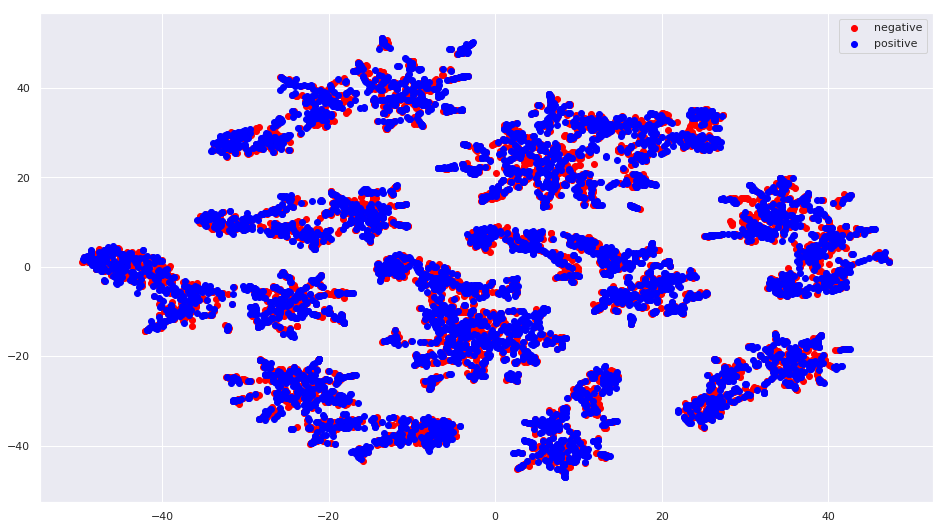

In [33]:
plt.figure(figsize=(16, 9))
colors = ['red','blue']
for no, i in enumerate(unique_label):
    plt.scatter(X[encoded==i,0],X[encoded==i,1],label=unique_label[no],color=colors[no])
plt.legend(['negative','positive'])
plt.show()